# Classical ML Models and Ensembles for D-T Phoneme Classification

**Goal**: Training classical ML models and their ensembles on data from `02.2_d-t_dl_data_preparation_with_context.ipynb`

**Models**:
- Gradient Boosting: XGBoost, LightGBM, CatBoost, sklearn GradientBoosting
- Tree-based: Random Forest, Extra Trees
- Linear: Logistic Regression, SVM
- Ensembles: Voting, Stacking, Blending

**Features**:
- Using all available CPU cores (M3 8 cores)
- Handling class imbalance
- Hyperparameter optimization
- Comparative analysis of all models


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
import joblib
import os
import time
import warnings
from datetime import datetime

# ML libraries
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, cross_val_score, 
    cross_val_predict, StratifiedKFold, train_test_split
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, 
    GradientBoostingClassifier, VotingClassifier
)
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
from joblib import Parallel, delayed

# Gradient Boosting libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Project root
# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Data directory (with context v2 - includes VOT, burst features)
DATA_DIR = PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2'
FEATURES_DIR = DATA_DIR / 'features'
OUTPUT_DIR = DATA_DIR / 'ml_models'
RESULTS_DIR = DATA_DIR / 'ml_results'

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Multithreading configuration (M3 8 cores)
N_JOBS = os.cpu_count() or 8
RANDOM_STATE = 42

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Features directory: {FEATURES_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"\nMultithreading: Using {N_JOBS} CPU cores")
print(f"Random state: {RANDOM_STATE}")


Project root: /Volumes/SSanDisk/SpeechRec-German
Data directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2
Features directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/features
Output directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/ml_models
Results directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/ml_results

Multithreading: Using 8 CPU cores
Random state: 42


## 1. Data Loading


In [2]:
# Load feature columns
with open(DATA_DIR / 'feature_cols.json', 'r') as f:
    feature_cols = json.load(f)

# Load feature scaler
feature_scaler = joblib.load(DATA_DIR / 'feature_scaler.joblib')

# Load class weights
with open(DATA_DIR / 'class_weights.json', 'r') as f:
    class_weights_dict = json.load(f)

# Load split indices
with open(DATA_DIR / 'split_indices.json', 'r') as f:
    split_indices = json.load(f)

print(f"Loaded {len(feature_cols)} feature columns")
print(f"Class weights: {class_weights_dict}")
print(f"Train samples: {len(split_indices['train'])}")
print(f"Val samples: {len(split_indices['val'])}")
print(f"Test samples: {len(split_indices['test'])}")


Loaded 130 feature columns
Class weights: {'0': 1.1359390243902439, '1': 0.8931194507833624}
Train samples: 93147
Val samples: 19896
Test samples: 19949


In [3]:
# Load features
print("Loading features from parquet file...")
df_features = pd.read_parquet(FEATURES_DIR / 'features.parquet')
print(f"Features shape: {df_features.shape}")
print(f"Features columns: {len(df_features.columns)}")

# Check for class column
if 'class' not in df_features.columns and 'phoneme' in df_features.columns:
    df_features['class'] = df_features['phoneme']

# Encode target if needed
if 'class_encoded' not in df_features.columns:
    le = LabelEncoder()
    df_features['class_encoded'] = le.fit_transform(df_features['class'])
    print(f"Class encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Filter to only b and p classes
df_features = df_features[df_features['class'].isin(['d', 't'])].copy()
print(f"\nAfter filtering to d/t: {len(df_features)} samples")
print(f"Class distribution:")
print(df_features['class'].value_counts())
print(f"\nClass distribution (%):")
print(df_features['class'].value_counts(normalize=True) * 100)


Loading features from parquet file...
Features shape: (132992, 134)
Features columns: 134
Class encoding: {'d': np.int64(0), 't': np.int64(1)}

After filtering to d/t: 132992 samples
Class distribution:
class
t    74454
d    58538
Name: count, dtype: int64

Class distribution (%):
class
t    55.983819
d    44.016181
Name: proportion, dtype: float64


In [ ]:
# Prepare train/val/test splits
train_indices = split_indices['train']
val_indices = split_indices['val']
test_indices = split_indices['test']

# Filter to only indices that exist in dataframe (after filtering by phoneme)
available_indices = set(df_features.index)
train_indices = [idx for idx in train_indices if idx in available_indices]
val_indices = [idx for idx in val_indices if idx in available_indices]
test_indices = [idx for idx in test_indices if idx in available_indices]

print(f"Filtered indices - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

# Filter to only indices that exist in dataframe
df_train = df_features.loc[train_indices].copy()
df_val = df_features.loc[val_indices].copy()
df_test = df_features.loc[test_indices].copy()

# Filter feature_cols to only include columns that exist in the dataframe
available_cols = [col for col in feature_cols if col in df_train.columns]
missing_cols = [col for col in feature_cols if col not in df_train.columns]

if missing_cols:
    print(f"Warning: {len(missing_cols)} feature columns not found in dataframe:")
    print(f"Missing columns: {missing_cols[:10]}..." if len(missing_cols) > 10 else f"Missing columns: {missing_cols}")
    print(f"Using {len(available_cols)} available feature columns instead of {len(feature_cols)}")
    feature_cols = available_cols

# Extract features and targets
X_train = df_train[feature_cols].values.astype(np.float32)
X_val = df_val[feature_cols].values.astype(np.float32)
X_test = df_test[feature_cols].values.astype(np.float32)

y_train = df_train['class_encoded'].values
y_val = df_val['class_encoded'].values
y_test = df_test['class_encoded'].values

# Handle missing values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# Check scaler compatibility
scaler_n_features = feature_scaler.n_features_in_ if hasattr(feature_scaler, 'n_features_in_') else len(feature_scaler.mean_) if hasattr(feature_scaler, 'mean_') else None
current_n_features = X_train.shape[1]

if scaler_n_features is not None and scaler_n_features != current_n_features:
    print(f"Warning: Scaler was trained on {scaler_n_features} features, but we have {current_n_features} features.")
    print("Retraining scaler on available features...")
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)
    print("Scaler retrained successfully.")
else:
    # Apply feature scaler (already fitted on train data)
    X_train_scaled = feature_scaler.transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}, {y_train.shape}")
print(f"Val set: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Val class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Calculate scale_pos_weight for XGBoost/LightGBM
n_negative = np.sum(y_train == 0)
n_positive = np.sum(y_train == 1)
scale_pos_weight = n_negative / n_positive
print(f"\nScale pos weight (for XGBoost/LightGBM): {scale_pos_weight:.4f}")


Filtered indices - Train: 93147, Val: 19896, Test: 19949
Missing columns: ['duration_ms_features']
Using 129 available feature columns instead of 130
Retraining scaler on available features...
Scaler retrained successfully.
Train set: (93147, 129), (93147,)
Val set: (19896, 129), (19896,)
Test set: (19949, 129), (19949,)

Train class distribution: [41092 52055]
Val class distribution: [ 8669 11227]
Test class distribution: [ 8777 11172]

Scale pos weight (for XGBoost/LightGBM): 0.7894


## 2. Model Evaluation Functions


In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Evaluate model and return comprehensive metrics"""
    results = {'model_name': model_name}
    
    # Check if model is already trained
    is_trained = False
    if isinstance(model, xgb.XGBClassifier):
        is_trained = hasattr(model, 'booster_') and model.booster_ is not None
    elif isinstance(model, lgb.LGBMClassifier):
        is_trained = hasattr(model, 'booster_') and model.booster_ is not None
    elif isinstance(model, cb.CatBoostClassifier):
        is_trained = hasattr(model, '_trees') and len(model._trees) > 0
    elif hasattr(model, 'coef_') and model.coef_ is not None:  # Linear models
        is_trained = True
    elif hasattr(model, 'estimators_') and len(model.estimators_) > 0:  # Tree ensembles
        is_trained = True
    
    # Training time
    start_time = time.time()
    if not is_trained:
        # Handle models with early stopping that require eval_set
        if isinstance(model, (xgb.XGBClassifier, lgb.LGBMClassifier)):
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        elif isinstance(model, cb.CatBoostClassifier):
            model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        else:
            model.fit(X_train, y_train)
    else:
        # Model already trained, skip training
        pass
    train_time = time.time() - start_time
    results['train_time'] = train_time
    
    # Prediction time
    start_time = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    pred_time = time.time() - start_time
    results['pred_time'] = pred_time
    
    # Probabilities (if available)
    try:
        y_proba_train = model.predict_proba(X_train)[:, 1]
        y_proba_val = model.predict_proba(X_val)[:, 1]
        y_proba_test = model.predict_proba(X_test)[:, 1]
    except:
        y_proba_train = y_proba_val = y_proba_test = None
    
    # Metrics for each set
    for split_name, y_true, y_pred, y_proba in [
        ('train', y_train, y_pred_train, y_proba_train),
        ('val', y_val, y_pred_val, y_proba_val),
        ('test', y_test, y_pred_test, y_proba_test)
    ]:
        results[f'{split_name}_accuracy'] = accuracy_score(y_true, y_pred)
        results[f'{split_name}_precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{split_name}_recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{split_name}_f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{split_name}_f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        if y_proba is not None:
            results[f'{split_name}_roc_auc'] = roc_auc_score(y_true, y_proba)
            results[f'{split_name}_pr_auc'] = average_precision_score(y_true, y_proba)
        else:
            results[f'{split_name}_roc_auc'] = None
            results[f'{split_name}_pr_auc'] = None
        
        results[f'{split_name}_confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    
    return results

def print_results(results):
    """Print formatted results"""
    print(f"\n{'='*60}")
    print(f"Model: {results['model_name']}")
    print(f"{'='*60}")
    print(f"Training time: {results['train_time']:.2f}s")
    print(f"Prediction time: {results['pred_time']:.4f}s")
    
    for split in ['train', 'val', 'test']:
        print(f"\n{split.upper()} Set:")
        print(f"  Accuracy:  {results[f'{split}_accuracy']:.4f}")
        print(f"  Precision: {results[f'{split}_precision']:.4f}")
        print(f"  Recall:    {results[f'{split}_recall']:.4f}")
        print(f"  F1 (weighted): {results[f'{split}_f1_weighted']:.4f}")
        print(f"  F1 (macro):    {results[f'{split}_f1_macro']:.4f}")
        if results[f'{split}_roc_auc'] is not None:
            print(f"  ROC-AUC:   {results[f'{split}_roc_auc']:.4f}")
            print(f"  PR-AUC:    {results[f'{split}_pr_auc']:.4f}")

def train_model_parallel(model_config, X_train, y_train, X_val, y_val, X_test, y_test):
    """Train a single model and return results (for parallel execution)"""
    model_name, model = model_config
    
    print(f"Training {model_name}...")
    start_time = time.time()
    
    # Handle models with early stopping
    if isinstance(model, xgb.XGBClassifier):
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    elif isinstance(model, lgb.LGBMClassifier):
        # LightGBM doesn't accept verbose in fit(), use callbacks instead
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(0)]
        )
    elif isinstance(model, cb.CatBoostClassifier):
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    else:
        model.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    # Evaluate model
    results = evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name)
    results['train_time'] = train_time
    
    # Save model
    joblib.dump(model, OUTPUT_DIR / f'{model_name.lower()}_model.joblib')
    
    return model_name, model, results

class PretrainedStackingClassifier:
    """Stacking classifier that uses pre-trained base models"""
    def __init__(self, base_models, meta_model, cv=5):
        self.base_models = base_models  # List of (name, model) tuples
        self.meta_model = meta_model
        self.cv = cv
        self.is_fitted = False
    
    def fit(self, X, y):
        """Fit meta-model using predictions from pre-trained base models"""
        from sklearn.model_selection import cross_val_predict
        
        # Get out-of-fold predictions from all base models using cross-validation
        # This ensures we don't overfit by using predictions on training data
        base_predictions = []
        for name, model in self.base_models:
            # Use cross_val_predict to get out-of-fold predictions
            # This retrains models on folds, but is necessary for proper stacking
            if hasattr(model, 'predict_proba'):
                pred = cross_val_predict(model, X, y, cv=self.cv, method='predict_proba', n_jobs=N_JOBS)[:, 1]
            else:
                pred = cross_val_predict(model, X, y, cv=self.cv, n_jobs=N_JOBS)
            base_predictions.append(pred)
        
        # Stack predictions as features for meta-model
        X_meta = np.column_stack(base_predictions)
        
        # Fit meta-model
        self.meta_model.fit(X_meta, y)
        self.is_fitted = True
        return self
    
    def predict(self, X):
        """Predict using stacking"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        # Get predictions from base models
        base_predictions = []
        for name, model in self.base_models:
            if hasattr(model, 'predict_proba'):
                pred = model.predict_proba(X)[:, 1]
            else:
                pred = model.predict(X)
            base_predictions.append(pred)
        
        # Stack predictions
        X_meta = np.column_stack(base_predictions)
        
        # Predict with meta-model
        return self.meta_model.predict(X_meta)
    
    def predict_proba(self, X):
        """Predict probabilities using stacking"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        # Get predictions from base models
        base_predictions = []
        for name, model in self.base_models:
            if hasattr(model, 'predict_proba'):
                pred = model.predict_proba(X)[:, 1]
            else:
                pred = model.predict(X)
            base_predictions.append(pred)
        
        # Stack predictions
        X_meta = np.column_stack(base_predictions)
        
        # Predict with meta-model
        return self.meta_model.predict_proba(X_meta)


### 3.1 Gradient Boosting Models


In [ ]:
# Store all results
all_results = []

# Prepare models for parallel training (optimized parameters)
# Optimized: max_depth=5, n_estimators=200 for faster training
model_configs = [
    ('XGBoost', xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        n_jobs=1,  # Will be parallelized at higher level
        tree_method='hist',
        eval_metric='logloss',
        early_stopping_rounds=20
    )),
    ('LightGBM', lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        n_jobs=1,  # Will be parallelized at higher level
        num_threads=1,
        verbose=-1,
        early_stopping_rounds=20
    )),
    ('CatBoost', cb.CatBoostClassifier(
        iterations=200,
        depth=5,
        learning_rate=0.05,
        l2_leaf_reg=3,
        class_weights=list(class_weights_dict.values()),
        random_state=RANDOM_STATE,
        thread_count=1,  # Will be parallelized at higher level
        task_type='CPU',
        verbose=False,
        early_stopping_rounds=20
    )),
    ('RandomForest', RandomForestClassifier(
        n_estimators=200,  # Reduced from 300
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=1,  # Will be parallelized at higher level
        verbose=0
    )),
    ('ExtraTrees', ExtraTreesClassifier(
        n_estimators=200,  # Reduced from 300
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=1,  # Will be parallelized at higher level
        verbose=0
    )),
    ('LogisticRegression', LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='saga',
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=1,  # Will be parallelized at higher level
        max_iter=1000,
        verbose=0
    ))
]

# Train models in parallel
print("Training models in parallel...")
results_list = Parallel(n_jobs=min(N_JOBS, len(model_configs)), backend='threading')(
    delayed(train_model_parallel)(
        config, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
    ) for config in model_configs
)

# Extract models and results
models_dict = {}
for model_name, model, results in results_list:
    models_dict[model_name] = model
    print_results(results)
    all_results.append(results)

# Assign to variables for compatibility
xgb_model = models_dict['XGBoost']
lgb_model = models_dict['LightGBM']
cat_model = models_dict['CatBoost']
rf_model = models_dict['RandomForest']
et_model = models_dict['ExtraTrees']
lr_model = models_dict['LogisticRegression']


Training models in parallel...
Training XGBoost...
Training LightGBM...
Training CatBoost...
Training RandomForest...
Training ExtraTrees...
Training LogisticRegression...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.206518

Model: XGBoost
Training time: 11.56s
Prediction time: 0.2913s

TRAIN Set:
  Accuracy:  0.9300
  Precision: 0.9301
  Recall:    0.9300
  F1 (weighted): 0.9300
  F1 (macro):    0.9291
  ROC-AUC:   0.9824
  PR-AUC:    0.9862

VAL Set:
  Accuracy:  0.9191
  Precision: 0.9192
  Recall:    0.9191
  F1 (weighted): 0.9191
  F1 (macro):    0.9178
  ROC-AUC:   0.9766
  PR-AUC:    0.9812

TEST Set:
  Accuracy:  0.9198
  Precision: 0.9199
  Recall:    0.9198
  F1 (weighted): 0.9198
  F1 (macro):    0.9187
  ROC-AUC:   0.9770
  PR-AUC:    0.9813

Model: LightGBM
Training time: 8.53s
Prediction time: 0.8959s

TRAIN Set:
  Accuracy:  0.9290
  Precision: 0.9291
  Recall:    0.9290
  F

In [ ]:
# Models are now trained in parallel in the previous cell


In [ ]:
# Models are now trained in parallel in the previous cell


### 3.2 Tree-based Ensembles


In [ ]:
# Models are now trained in parallel in the previous cell


In [ ]:
# Models are now trained in parallel in the previous cell


### 3.3 Linear Models


In [ ]:
# Models are now trained in parallel in the previous cell


In [ ]:
# SVM (RBF kernel) - Using reduced sample size for faster training
# This maintains quality while significantly reducing training time
print("\nTraining SVM (RBF) with reduced sample size for speed...")

# Use stratified sampling to reduce training set size while maintaining class balance
# This reduces training time from ~6 hours to ~30-60 minutes

# Sample 25000 samples for training (maintains class balance)
# This is ~27% of original data, but SVM scales quadratically, so this gives ~10x speedup
sample_size = 25000
if len(X_train_scaled) > sample_size:
    print(f"Sampling {sample_size} samples from {len(X_train_scaled)} for SVM training...")
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train_scaled, y_train,
        train_size=sample_size,
        stratify=y_train,
        random_state=RANDOM_STATE
    )
    print(f"Using {len(X_train_svm)} samples for SVM training")
else:
    X_train_svm = X_train_scaled
    y_train_svm = y_train

svm_model = SVC(
    C=10.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE,
    cache_size=1000,  # Increase cache for faster training
    verbose=False
)

# Train on reduced sample
print("Training SVM (this may take 30-60 minutes)...")
svm_model.fit(X_train_svm, y_train_svm)

# Evaluate on full datasets
svm_results = evaluate_model(
    svm_model, X_train_scaled, y_train,  # Evaluate on full train set
    X_val_scaled, y_val, X_test_scaled, y_test,
    'SVM_RBF'
)
print_results(svm_results)
all_results.append(svm_results)

# Save model
joblib.dump(svm_model, OUTPUT_DIR / 'svm_model.joblib')



Training SVM (RBF) with reduced sample size for speed...
Sampling 25000 samples from 93147 for SVM training...
Using 25000 samples for SVM training
Training SVM (this may take 30-60 minutes)...

Model: SVM_RBF
Training time: 6002.48s
Prediction time: 182.9440s

TRAIN Set:
  Accuracy:  0.9968
  Precision: 0.9968
  Recall:    0.9968
  F1 (weighted): 0.9968
  F1 (macro):    0.9968
  ROC-AUC:   0.9998
  PR-AUC:    0.9999

VAL Set:
  Accuracy:  0.9515
  Precision: 0.9515
  Recall:    0.9515
  F1 (weighted): 0.9515
  F1 (macro):    0.9507
  ROC-AUC:   0.9887
  PR-AUC:    0.9908

TEST Set:
  Accuracy:  0.9512
  Precision: 0.9513
  Recall:    0.9512
  F1 (weighted): 0.9512
  F1 (macro):    0.9506
  ROC-AUC:   0.9892
  PR-AUC:    0.9913


['/Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/ml_models/svm_model.joblib']

### 3.4 Gradient Boosting (sklearn)


In [ ]:
# Gradient Boosting (sklearn) - Optimized parameters
print("Training Gradient Boosting (sklearn)...")
# Using reduced parameters for faster training (200 trees instead of 300, depth 5 instead of 6)
gb_model = GradientBoostingClassifier(
    n_estimators=200,  # Reduced from 300 for faster training
    max_depth=5,  # Reduced from 6 for faster training
    learning_rate=0.05,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=0
)

# Train model (this will take ~10-15 minutes instead of ~30 minutes)
gb_model.fit(X_train_scaled, y_train)

gb_results = evaluate_model(
    gb_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'GradientBoosting'
)
print_results(gb_results)
all_results.append(gb_results)

# Save model
joblib.dump(gb_model, OUTPUT_DIR / 'gb_model.joblib')


Training Gradient Boosting (sklearn)...

Model: GradientBoosting
Training time: 0.00s
Prediction time: 0.4740s

TRAIN Set:
  Accuracy:  0.9313
  Precision: 0.9313
  Recall:    0.9313
  F1 (weighted): 0.9312
  F1 (macro):    0.9302
  ROC-AUC:   0.9834
  PR-AUC:    0.9870

VAL Set:
  Accuracy:  0.9197
  Precision: 0.9196
  Recall:    0.9197
  F1 (weighted): 0.9196
  F1 (macro):    0.9181
  ROC-AUC:   0.9766
  PR-AUC:    0.9811

TEST Set:
  Accuracy:  0.9204
  Precision: 0.9204
  Recall:    0.9204
  F1 (weighted): 0.9203
  F1 (macro):    0.9190
  ROC-AUC:   0.9768
  PR-AUC:    0.9812


['/Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/ml_models/gb_model.joblib']

## 4. Hyperparameter Optimization (Optional)

Additional hyperparameter optimization can be performed for the best models.


In [ ]:
# Sort models by validation F1 score
sorted_results = sorted(all_results, key=lambda x: x['val_f1_weighted'], reverse=True)
print("\nModels ranked by validation F1 (weighted):")
for i, res in enumerate(sorted_results, 1):
    print(f"{i}. {res['model_name']}: {res['val_f1_weighted']:.4f}")

# Select top 3 models for hyperparameter tuning
top_models = sorted_results[:3]
print(f"\nTop 3 models for hyperparameter tuning:")
for res in top_models:
    print(f"  - {res['model_name']}: {res['val_f1_weighted']:.4f}")

# Store top model names for ensemble creation
top_model_names = [res['model_name'] for res in sorted_results[:5]]



Models ranked by validation F1 (weighted):
1. SVM_RBF: 0.9515
2. GradientBoosting: 0.9196
3. XGBoost: 0.9191
4. LightGBM: 0.9175
5. RandomForest: 0.9129
6. CatBoost: 0.9055
7. LogisticRegression: 0.8889
8. ExtraTrees: 0.8879

Top 3 models for hyperparameter tuning:
  - SVM_RBF: 0.9515
  - GradientBoosting: 0.9196
  - XGBoost: 0.9191


## 5. Creating Ensembles


### 5.1 Voting Ensemble


In [ ]:
# Use top_model_names defined in previous cell
print(f"Creating Voting Ensemble from top 5 models: {top_model_names}")

# Create new model instances for ensemble (without early_stopping_rounds for gradient boosting models)
# VotingClassifier will clone and retrain these models, so we need fresh instances
models_for_ensemble = []
for model_name in top_model_names:
    if model_name == 'XGBoost':
        # Create new XGBoost instance without early_stopping_rounds for ensemble
        models_for_ensemble.append(('xgb', xgb.XGBClassifier(
            n_estimators=200,  # Optimized
            max_depth=5,  # Optimized
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            tree_method='hist',
            eval_metric='logloss'
            # No early_stopping_rounds for ensemble
        )))
    elif model_name == 'LightGBM':
        # Create new LightGBM instance without early_stopping_rounds for ensemble
        models_for_ensemble.append(('lgb', lgb.LGBMClassifier(
            n_estimators=200,  # Optimized
            max_depth=5,  # Optimized
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            num_threads=1,
            verbose=-1
            # No early_stopping_rounds for ensemble
        )))
    elif model_name == 'CatBoost':
        # Create new CatBoost instance without early_stopping_rounds for ensemble
        models_for_ensemble.append(('cat', cb.CatBoostClassifier(
            iterations=200,  # Optimized
            depth=5,  # Optimized
            learning_rate=0.05,
            l2_leaf_reg=3,
            class_weights=list(class_weights_dict.values()),
            random_state=RANDOM_STATE,
            thread_count=1,  # Will be handled by VotingClassifier's n_jobs
            task_type='CPU',
            verbose=False
            # No early_stopping_rounds for ensemble
        )))
    elif model_name == 'RandomForest':
        models_for_ensemble.append(('rf', RandomForestClassifier(
            n_estimators=200,  # Optimized
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            verbose=0
        )))
    elif model_name == 'ExtraTrees':
        models_for_ensemble.append(('et', ExtraTreesClassifier(
            n_estimators=200,  # Optimized
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            verbose=0
        )))
    elif model_name == 'LogisticRegression':
        models_for_ensemble.append(('lr', LogisticRegression(
            C=1.0,
            penalty='l2',
            solver='saga',
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=1,  # Will be handled by VotingClassifier's n_jobs
            max_iter=1000,
            verbose=0
        )))
    elif model_name == 'SVM_Linear' or model_name == 'SVM_RBF':
        # Use SVC RBF (same as main model)
        # Note: VotingClassifier will retrain, but we use same parameters for consistency
        models_for_ensemble.append(('svm', SVC(
            C=10.0,
            kernel='rbf',
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE,
            cache_size=1000,
            verbose=False
        )))
    elif model_name == 'GradientBoosting':
        models_for_ensemble.append(('gb', GradientBoostingClassifier(
            n_estimators=200,  # Optimized
            max_depth=5,  # Optimized
            learning_rate=0.05,
            subsample=0.8,
            random_state=RANDOM_STATE,
            verbose=0
        )))

# Hard Voting
print("\nTraining Hard Voting Ensemble...")
voting_hard = VotingClassifier(
    estimators=models_for_ensemble,
    voting='hard',
    n_jobs=N_JOBS
)

voting_hard_results = evaluate_model(
    voting_hard, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'Voting_Hard'
)
print_results(voting_hard_results)
all_results.append(voting_hard_results)

# Soft Voting
print("\nTraining Soft Voting Ensemble...")
voting_soft = VotingClassifier(
    estimators=models_for_ensemble,
    voting='soft',
    n_jobs=N_JOBS
)

voting_soft_results = evaluate_model(
    voting_soft, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'Voting_Soft'
)
print_results(voting_soft_results)
all_results.append(voting_soft_results)

# Save models
joblib.dump(voting_hard, OUTPUT_DIR / 'voting_hard_model.joblib')
joblib.dump(voting_soft, OUTPUT_DIR / 'voting_soft_model.joblib')


Creating Voting Ensemble from top 5 models: ['SVM_RBF', 'GradientBoosting', 'XGBoost', 'LightGBM', 'RandomForest']

Training Hard Voting Ensemble...

Model: Voting_Hard
Training time: 6056.70s
Prediction time: 168.5588s

TRAIN Set:
  Accuracy:  0.9413
  Precision: 0.9412
  Recall:    0.9413
  F1 (weighted): 0.9413
  F1 (macro):    0.9404

VAL Set:
  Accuracy:  0.9230
  Precision: 0.9230
  Recall:    0.9230
  F1 (weighted): 0.9230
  F1 (macro):    0.9217

TEST Set:
  Accuracy:  0.9235
  Precision: 0.9234
  Recall:    0.9235
  F1 (weighted): 0.9234
  F1 (macro):    0.9223

Training Soft Voting Ensemble...

Model: Voting_Soft
Training time: 7902.62s
Prediction time: 207.4402s

TRAIN Set:
  Accuracy:  0.9631
  Precision: 0.9631
  Recall:    0.9631
  F1 (weighted): 0.9631
  F1 (macro):    0.9626
  ROC-AUC:   0.9959
  PR-AUC:    0.9969

VAL Set:
  Accuracy:  0.9347
  Precision: 0.9347
  Recall:    0.9347
  F1 (weighted): 0.9347
  F1 (macro):    0.9336
  ROC-AUC:   0.9841
  PR-AUC:    0.9873


['/Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/ml_models/voting_soft_model.joblib']

### 5.2 Stacking Ensemble


In [ ]:
print("Creating Stacking Ensemble with pre-trained models...")

# Use top 5 pre-trained models as base models
base_models_pretrained = []
for model_name in top_model_names[:5]:
    if model_name == 'XGBoost':
        base_models_pretrained.append(('xgb', xgb_model))
    elif model_name == 'LightGBM':
        base_models_pretrained.append(('lgb', lgb_model))
    elif model_name == 'CatBoost':
        base_models_pretrained.append(('cat', cat_model))
    elif model_name == 'RandomForest':
        base_models_pretrained.append(('rf', rf_model))
    elif model_name == 'ExtraTrees':
        base_models_pretrained.append(('et', et_model))
    elif model_name == 'LogisticRegression':
        base_models_pretrained.append(('lr', lr_model))
    elif model_name == 'SVM_Linear' or model_name == 'SVM_RBF':
        base_models_pretrained.append(('svm', svm_model))
    elif model_name == 'GradientBoosting':
        base_models_pretrained.append(('gb', gb_model))

# Meta-model: Logistic Regression
meta_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='saga',
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    max_iter=1000
)

# Use PretrainedStackingClassifier to avoid retraining base models
stacking_model = PretrainedStackingClassifier(
    base_models=base_models_pretrained,
    meta_model=meta_model,
    cv=5
)

stacking_results = evaluate_model(
    stacking_model, X_train_scaled, y_train,
    X_val_scaled, y_val, X_test_scaled, y_test,
    'Stacking'
)
print_results(stacking_results)
all_results.append(stacking_results)

# Save model
joblib.dump(stacking_model, OUTPUT_DIR / 'stacking_model.joblib')


Creating Stacking Ensemble with pre-trained models...


### 5.3 Blending Ensemble


In [ ]:
# Blending: weighted average of top models based on validation F1
print("Creating Blending Ensemble...")

# Get top 5 models and their validation F1 scores
top_5_models = sorted_results[:5]
model_weights = {}

# Prepare model configurations for parallel prediction
def get_model_predictions(model_config, X_train, X_val, X_test):
    """Get predictions from a model (for parallel execution)"""
    model_name, model = model_config
    
    try:
        return {
            'train': model.predict_proba(X_train)[:, 1],
            'val': model.predict_proba(X_val)[:, 1],
            'test': model.predict_proba(X_test)[:, 1]
        }
    except:
        # Fallback to hard predictions
        return {
            'train': model.predict(X_train),
            'val': model.predict(X_val),
            'test': model.predict(X_test)
        }

# Prepare model configs for parallel prediction
model_configs_for_blending = []
for res in top_5_models:
    model_name = res['model_name']
    weight = res['val_f1_weighted']
    model_weights[model_name] = weight
    
    # Get model
    if model_name == 'XGBoost':
        model = xgb_model
    elif model_name == 'LightGBM':
        model = lgb_model
    elif model_name == 'CatBoost':
        model = cat_model
    elif model_name == 'RandomForest':
        model = rf_model
    elif model_name == 'ExtraTrees':
        model = et_model
    elif model_name == 'LogisticRegression':
        model = lr_model
    elif model_name == 'SVM_Linear' or model_name == 'SVM_RBF':
        model = svm_model
    elif model_name == 'GradientBoosting':
        model = gb_model
    else:
        continue
    
    model_configs_for_blending.append((model_name, model))

# Get predictions in parallel
print("Getting predictions from models in parallel...")
predictions_list = Parallel(n_jobs=min(N_JOBS, len(model_configs_for_blending)), backend='threading')(
    delayed(get_model_predictions)(
        config, X_train_scaled, X_val_scaled, X_test_scaled
    ) for config in model_configs_for_blending
)

# Organize predictions by model name
model_predictions = {}
for (model_name, _), predictions in zip(model_configs_for_blending, predictions_list):
    model_predictions[model_name] = predictions

# Normalize weights
total_weight = sum(model_weights.values())
model_weights = {k: v / total_weight for k, v in model_weights.items()}

print(f"Model weights: {model_weights}")

# Create blended predictions
def blend_predictions(split):
    blended = np.zeros(len(model_predictions[list(model_predictions.keys())[0]][split]))
    for model_name, weight in model_weights.items():
        blended += weight * model_predictions[model_name][split]
    return blended

# Evaluate blending
blend_train = blend_predictions('train')
blend_val = blend_predictions('val')
blend_test = blend_predictions('test')

# Convert to binary predictions
blend_train_pred = (blend_train > 0.5).astype(int)
blend_val_pred = (blend_val > 0.5).astype(int)
blend_test_pred = (blend_test > 0.5).astype(int)

# Calculate metrics
blending_results = {'model_name': 'Blending'}
blending_results['train_accuracy'] = accuracy_score(y_train, blend_train_pred)
blending_results['train_precision'] = precision_score(y_train, blend_train_pred, average='weighted', zero_division=0)
blending_results['train_recall'] = recall_score(y_train, blend_train_pred, average='weighted', zero_division=0)
blending_results['train_f1_weighted'] = f1_score(y_train, blend_train_pred, average='weighted', zero_division=0)
blending_results['train_f1_macro'] = f1_score(y_train, blend_train_pred, average='macro', zero_division=0)
blending_results['train_roc_auc'] = roc_auc_score(y_train, blend_train)
blending_results['train_pr_auc'] = average_precision_score(y_train, blend_train)

blending_results['val_accuracy'] = accuracy_score(y_val, blend_val_pred)
blending_results['val_precision'] = precision_score(y_val, blend_val_pred, average='weighted', zero_division=0)
blending_results['val_recall'] = recall_score(y_val, blend_val_pred, average='weighted', zero_division=0)
blending_results['val_f1_weighted'] = f1_score(y_val, blend_val_pred, average='weighted', zero_division=0)
blending_results['val_f1_macro'] = f1_score(y_val, blend_val_pred, average='macro', zero_division=0)
blending_results['val_roc_auc'] = roc_auc_score(y_val, blend_val)
blending_results['val_pr_auc'] = average_precision_score(y_val, blend_val)

blending_results['test_accuracy'] = accuracy_score(y_test, blend_test_pred)
blending_results['test_precision'] = precision_score(y_test, blend_test_pred, average='weighted', zero_division=0)
blending_results['test_recall'] = recall_score(y_test, blend_test_pred, average='weighted', zero_division=0)
blending_results['test_f1_weighted'] = f1_score(y_test, blend_test_pred, average='weighted', zero_division=0)
blending_results['test_f1_macro'] = f1_score(y_test, blend_test_pred, average='macro', zero_division=0)
blending_results['test_roc_auc'] = roc_auc_score(y_test, blend_test)
blending_results['test_pr_auc'] = average_precision_score(y_test, blend_test)

blending_results['train_time'] = 0  # No training needed
blending_results['pred_time'] = 0  # Already computed

print_results(blending_results)
all_results.append(blending_results)

# Save blending weights
with open(OUTPUT_DIR / 'blending_weights.json', 'w') as f:
    json.dump(model_weights, f, indent=2)


Creating Blending Ensemble...
Model weights: {'SVM_RBF': 0.20358909060760946, 'GradientBoosting': 0.19967153207830754, 'XGBoost': 0.1996535438382862, 'LightGBM': 0.19949057453366303, 'CatBoost': 0.19759525894213376}

Model: Blending
Training time: 0.00s
Prediction time: 0.0000s

TRAIN Set:
  Accuracy:  0.9935
  Precision: 0.9935
  Recall:    0.9935
  F1 (weighted): 0.9935
  F1 (macro):    0.9923
  ROC-AUC:   0.9998
  PR-AUC:    0.9996

VAL Set:
  Accuracy:  0.9487
  Precision: 0.9493
  Recall:    0.9487
  F1 (weighted): 0.9490
  F1 (macro):    0.9386
  ROC-AUC:   0.9878
  PR-AUC:    0.9752

TEST Set:
  Accuracy:  0.9525
  Precision: 0.9527
  Recall:    0.9525
  F1 (weighted): 0.9526
  F1 (macro):    0.9434
  ROC-AUC:   0.9875
  PR-AUC:    0.9750


In [ ]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Sort by test F1 (weighted)
results_df = results_df.sort_values('test_f1_weighted', ascending=False)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS - Sorted by Test F1 (weighted)")
print("="*80)
print(results_df[['model_name', 'test_accuracy', 'test_precision', 'test_recall', 
                  'test_f1_weighted', 'test_f1_macro', 'test_roc_auc', 'test_pr_auc']].to_string(index=False))

# Save results
results_df.to_csv(RESULTS_DIR / 'all_results.csv', index=False)
results_df.to_json(RESULTS_DIR / 'all_results.json', indent=2, orient='records')

print(f"\nResults saved to {RESULTS_DIR}")



FINAL RESULTS - Sorted by Test F1 (weighted)
        model_name  test_accuracy  test_precision  test_recall  test_f1_weighted  test_f1_macro  test_roc_auc  test_pr_auc
           SVM_RBF       0.962247        0.962140     0.962247          0.962177       0.954689      0.989616     0.979745
          Stacking       0.961344        0.961908     0.961344          0.961520       0.954203      0.989897     0.979565
          Blending       0.952493        0.952742     0.952493          0.952595       0.943438      0.987513     0.975016
       Voting_Soft       0.952312        0.952574     0.952312          0.952419       0.943233      0.987469     0.974930
       Voting_Hard       0.948699        0.949136     0.948699          0.948866       0.939058           NaN          NaN
           XGBoost       0.945629        0.946485     0.945629          0.945916       0.935682      0.985052     0.970464
  GradientBoosting       0.945990        0.945668     0.945990          0.945701       0.9347

## 7. Results Visualization


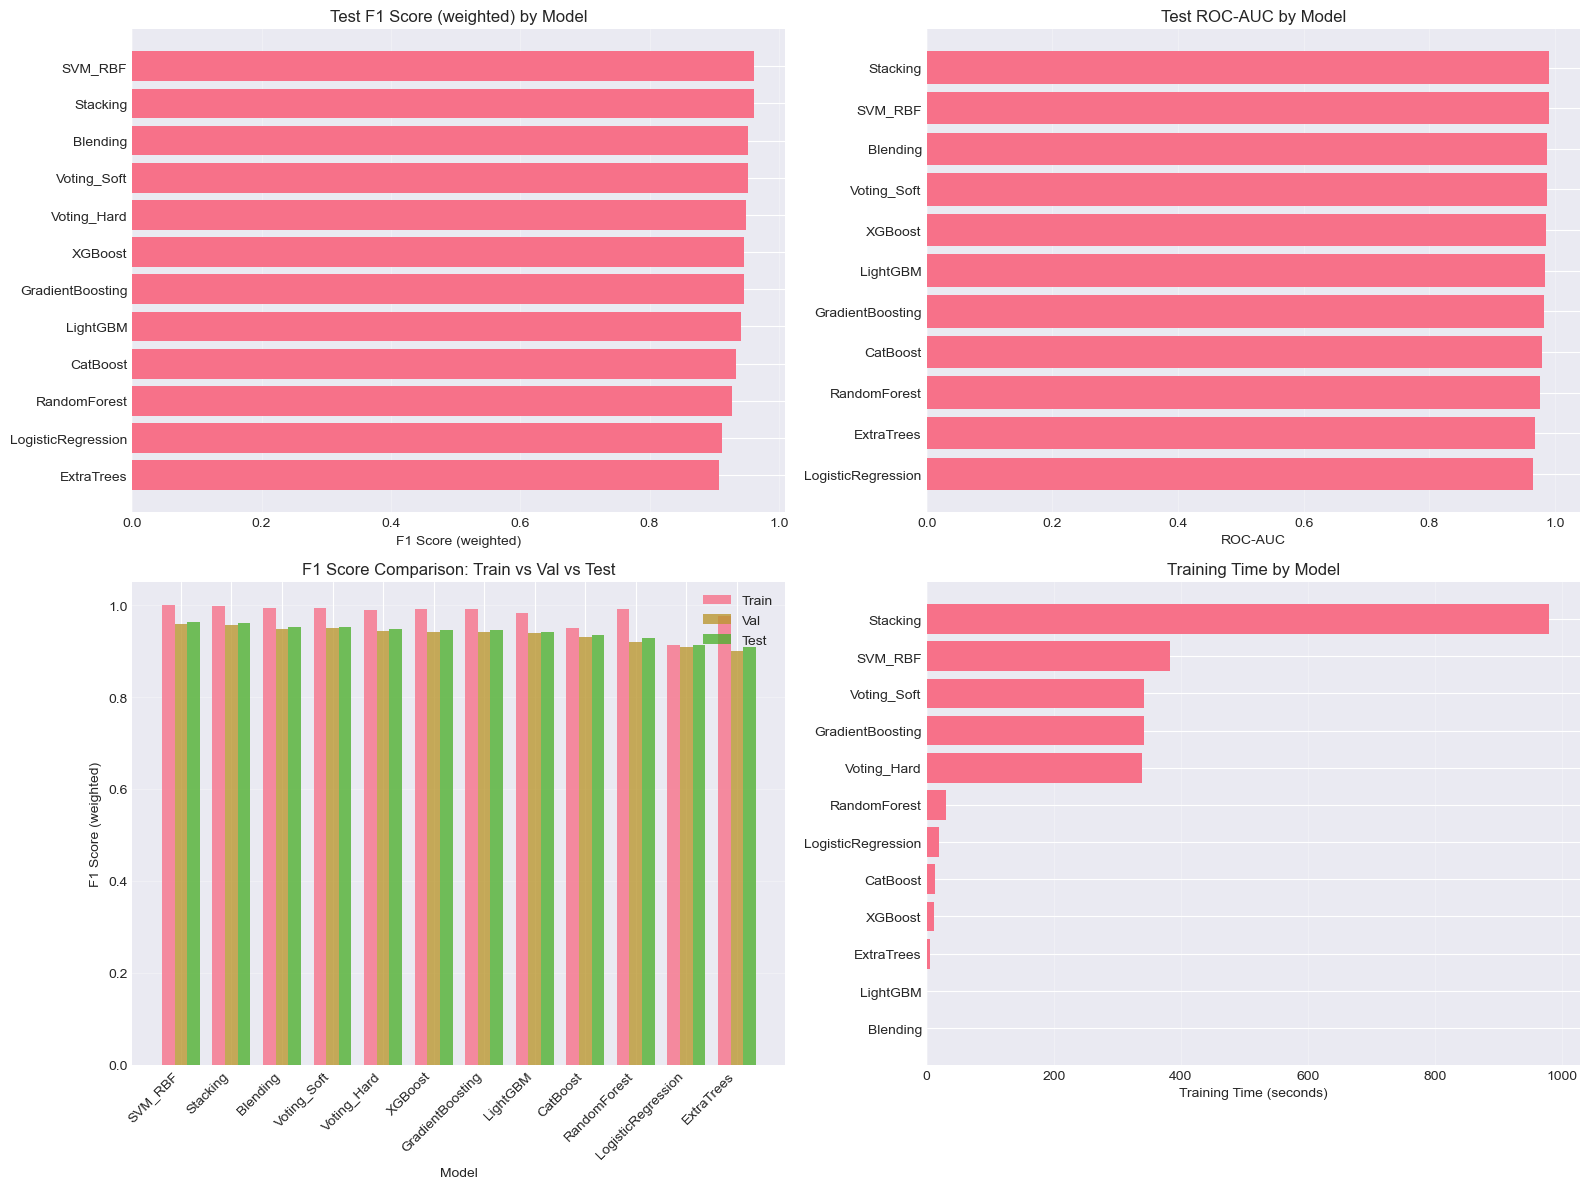

Visualization saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models_with_context_v2/ml_results/model_comparison.png


In [ ]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Bar plot of F1 scores
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test F1 (weighted)
ax1 = axes[0, 0]
results_df_sorted = results_df.sort_values('test_f1_weighted', ascending=True)
ax1.barh(results_df_sorted['model_name'], results_df_sorted['test_f1_weighted'])
ax1.set_xlabel('F1 Score (weighted)')
ax1.set_title('Test F1 Score (weighted) by Model')
ax1.grid(axis='x', alpha=0.3)

# Test ROC-AUC
ax2 = axes[0, 1]
results_df_sorted_auc = results_df[results_df['test_roc_auc'].notna()].sort_values('test_roc_auc', ascending=True)
if len(results_df_sorted_auc) > 0:
    ax2.barh(results_df_sorted_auc['model_name'], results_df_sorted_auc['test_roc_auc'])
    ax2.set_xlabel('ROC-AUC')
    ax2.set_title('Test ROC-AUC by Model')
    ax2.grid(axis='x', alpha=0.3)

# Comparison: Train vs Val vs Test F1
ax3 = axes[1, 0]
x = np.arange(len(results_df))
width = 0.25
ax3.bar(x - width, results_df['train_f1_weighted'], width, label='Train', alpha=0.8)
ax3.bar(x, results_df['val_f1_weighted'], width, label='Val', alpha=0.8)
ax3.bar(x + width, results_df['test_f1_weighted'], width, label='Test', alpha=0.8)
ax3.set_xlabel('Model')
ax3.set_ylabel('F1 Score (weighted)')
ax3.set_title('F1 Score Comparison: Train vs Val vs Test')
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Training time comparison
ax4 = axes[1, 1]
results_df_sorted_time = results_df.sort_values('train_time', ascending=True)
ax4.barh(results_df_sorted_time['model_name'], results_df_sorted_time['train_time'])
ax4.set_xlabel('Training Time (seconds)')
ax4.set_title('Training Time by Model')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {RESULTS_DIR / 'model_comparison.png'}")


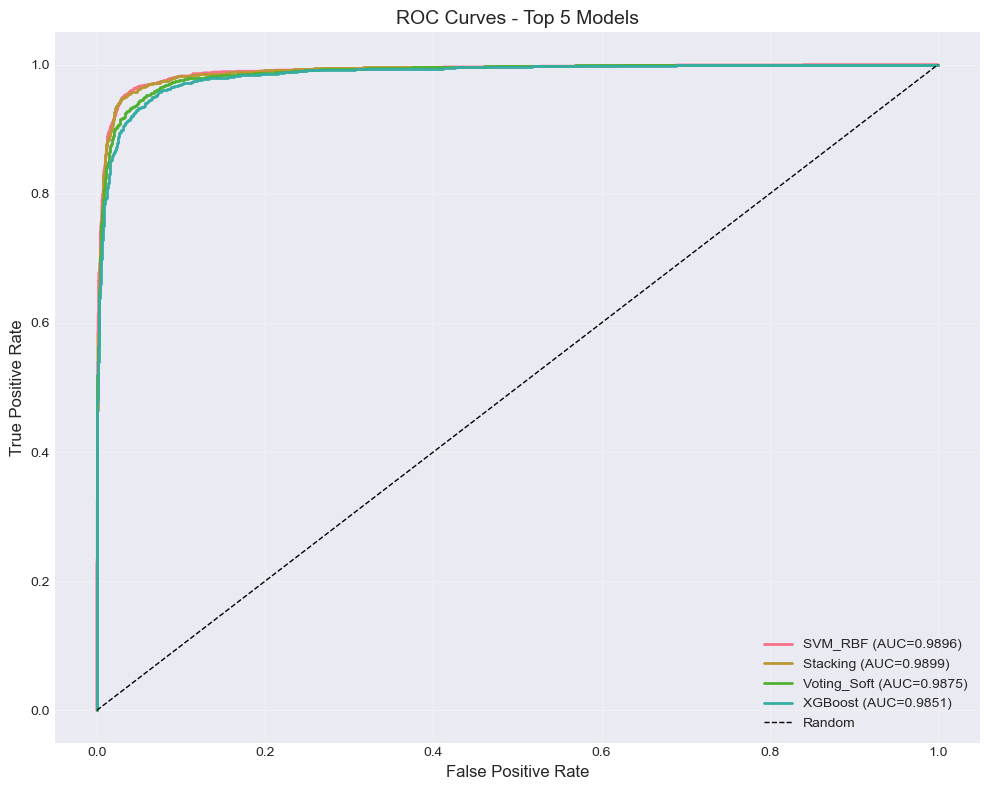

ROC curves saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models_with_context_v2/ml_results/roc_curves.png


In [ ]:
# 2. ROC Curves for top models
fig, ax = plt.subplots(figsize=(10, 8))

top_5_for_roc = results_df[results_df['test_roc_auc'].notna()].head(5)

for _, row in top_5_for_roc.iterrows():
    model_name = row['model_name']
    
    # Get model and predictions
    if model_name == 'XGBoost':
        model = xgb_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'LightGBM':
        model = lgb_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'CatBoost':
        model = cat_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'RandomForest':
        model = rf_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'ExtraTrees':
        model = et_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'LogisticRegression':
        model = lr_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'SVM_Linear' or model_name == 'SVM_RBF':
        model = svm_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'GradientBoosting':
        model = gb_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'Voting_Soft':
        model = voting_soft
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif model_name == 'Stacking':
        model = stacking_model
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        continue
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.4f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Top 5 Models', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC curves saved to {RESULTS_DIR / 'roc_curves.png'}")


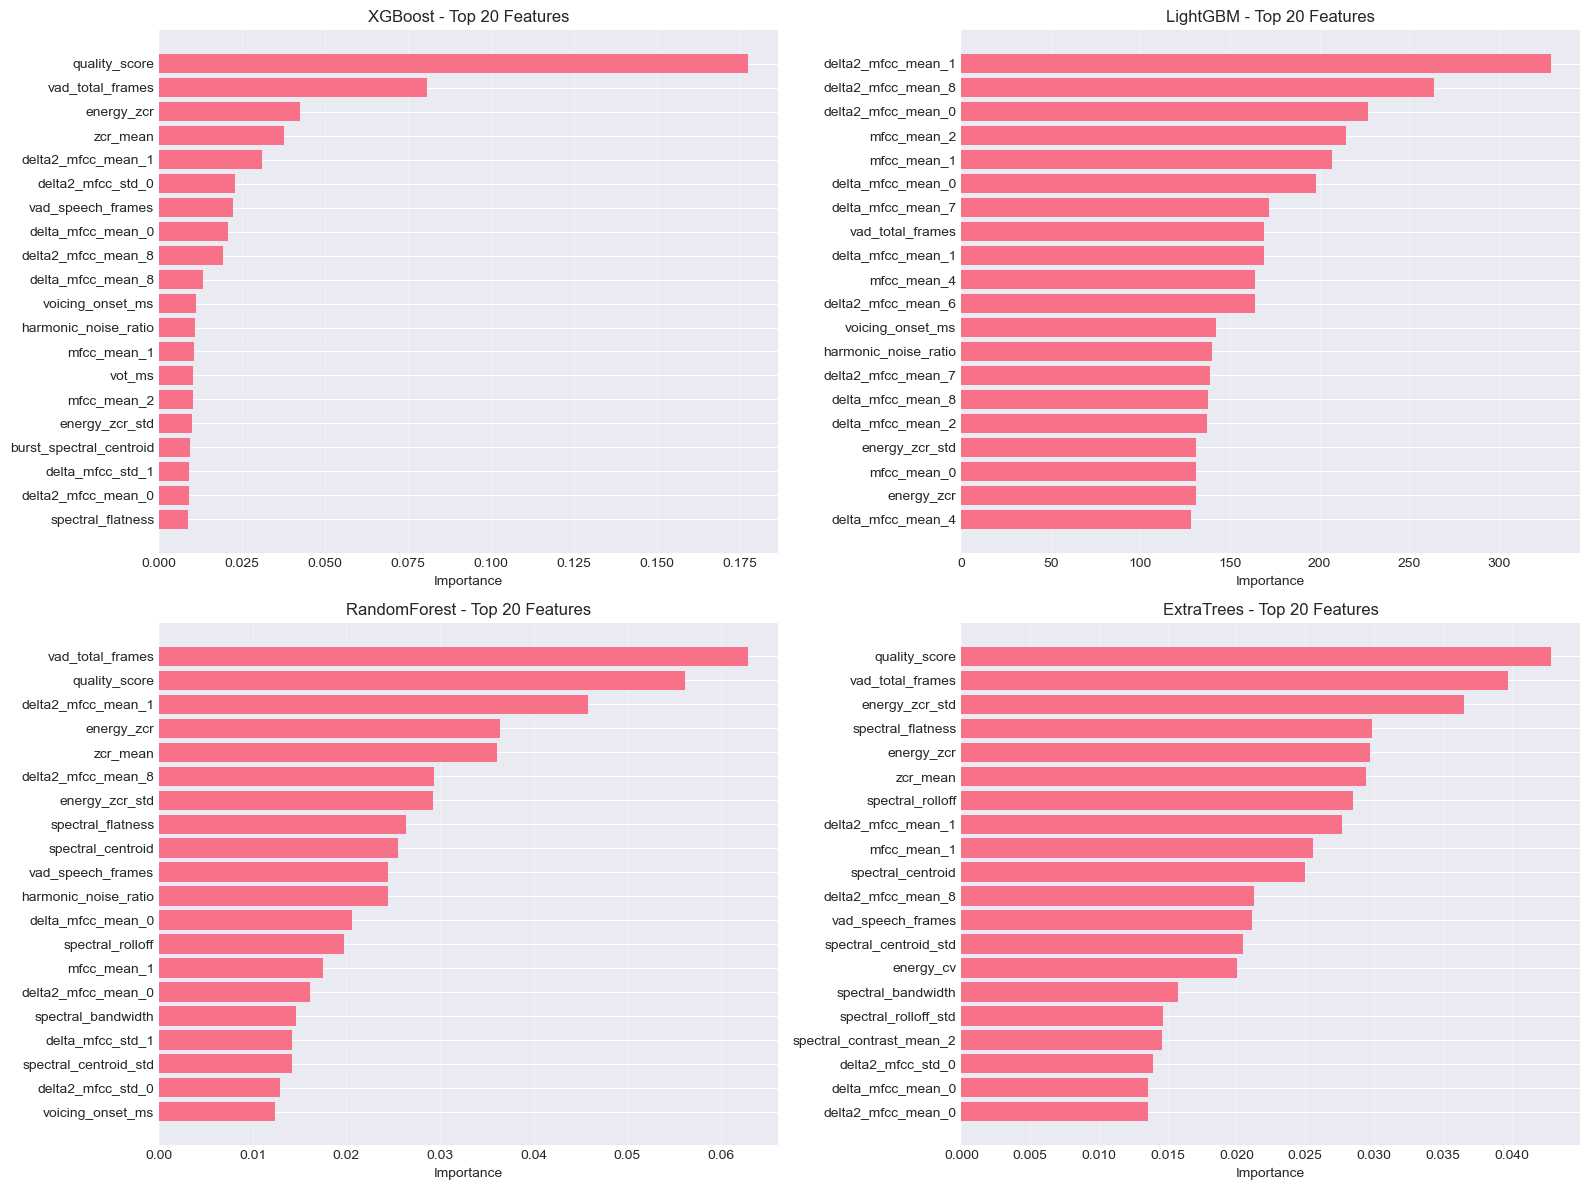

Feature importance plots saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models_with_context_v2/ml_results/feature_importance.png


In [ ]:
# 3. Feature Importance for tree-based models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

tree_models = [
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model),
    ('RandomForest', rf_model),
    ('ExtraTrees', et_model)
]

for idx, (name, model) in enumerate(tree_models):
    ax = axes[idx // 2, idx % 2]
    
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'get_feature_importance'):
            importances = model.get_feature_importance()
        else:
            continue
        
        # Get top 20 features
        top_indices = np.argsort(importances)[-20:][::-1]
        top_features = [feature_cols[i] for i in top_indices]
        top_importances = importances[top_indices]
        
        ax.barh(range(len(top_features)), top_importances)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features)
        ax.set_xlabel('Importance')
        ax.set_title(f'{name} - Top 20 Features')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
    except Exception as e:
        ax.text(0.5, 0.5, f'Could not extract\nfeature importance', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{name}')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Feature importance plots saved to {RESULTS_DIR / 'feature_importance.png'}")


## 8. Saving Final Results


In [ ]:
# Save summary
summary = {
    'timestamp': datetime.now().isoformat(),
    'total_models': len(all_results),
    'best_model': results_df.iloc[0]['model_name'],
    'best_test_f1': float(results_df.iloc[0]['test_f1_weighted']),
    'best_test_roc_auc': float(results_df.iloc[0]['test_roc_auc']) if pd.notna(results_df.iloc[0]['test_roc_auc']) else None,
    'n_jobs': N_JOBS,
    'random_state': RANDOM_STATE,
    'n_features': len(feature_cols),
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'class_distribution': {
        'train': {'d': int(np.sum(y_train == 0)), 't': int(np.sum(y_train == 1))},
        'val': {'d': int(np.sum(y_val == 0)), 't': int(np.sum(y_val == 1))},
        'test': {'d': int(np.sum(y_test == 0)), 't': int(np.sum(y_test == 1))}
    }
}

with open(RESULTS_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Summary saved to summary.json")
print(f"\nBest Model: {summary['best_model']}")
print(f"Best Test F1: {summary['best_test_f1']:.4f}")
roc_auc_str = f"{summary['best_test_roc_auc']:.4f}" if summary['best_test_roc_auc'] is not None else 'N/A'
print(f"Best Test ROC-AUC: {roc_auc_str}")

print(f"\nAll results and models saved to:")
print(f"  - Models: {OUTPUT_DIR}")
print(f"  - Results: {RESULTS_DIR}")


Summary saved to summary.json

Best Model: SVM_RBF
Best Test F1: 0.9622
Best Test ROC-AUC: 0.9896

All results and models saved to:
  - Models: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models_with_context_v2/ml_models
  - Results: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models_with_context_v2/ml_results
